# Hello Samplomatic!

In this tutorial, we take a deep dive into Samplomatic and its core concepts.<br>

After completing this tutorial, you will be able to:
- Utilize boxes and annotations to specify how you intend to randomize the content of a circuit.
- Generate randomized sets of parameters using the `samplex`.
- Execute randomized circuits on IBM&reg; QPUs through the `Executor` primitive.
- But above all, understand how to use Samplomatic, `NoiseLearnerV3`, and `Executor` to express a wide array of error mitigation protocols!

### Requirements

This notebook has the following Python dependencies:

```bash
pip install "qiskit[visualization]"
pip install "samplomatic[vis]"
pip install pip "qiskit-ibm-runtime @ git+https://github.com/Qiskit/qiskit-ibm-runtime.git@executor_preview
```

### Resources

- [Executor and Samplomatic Landing Page](https://quantum.cloud.ibm.com/docs/en/guides/directed-execution-model)
- GitHub: https://github.com/Qiskit/samplomatic
- API Docs: https://qiskit.github.io/samplomatic/
- Guides: https://qiskit.github.io/samplomatic/guides/index.html

## 1. Boxes and the `Twirl` annotation

Twirling is the process of inserting randomly-chosen gates before a noisy operation and undoing them afterward. This randomization does not mutate the intended computation, but it averages the noise into a simpler form. As an example, in Pauli twirling we sample gates from the group of Pauli gates, in order to average the noise to stochastic Pauli errors.

To see how to twirl the content of a circuit using Samplomatic, consider the following circuit, which prepares the three-qubit Greenberger–Horne–Zeilinger (GHZ) state:

$$ 
|\textrm{GHZ}\rangle_3=\frac{|000\rangle+|111\rangle}{\sqrt{2}},
$$

applies Pauli-X rotations, and measures the resulting state.

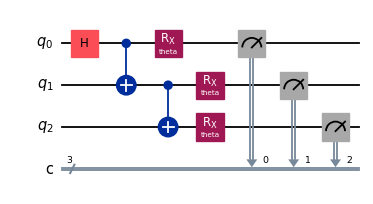

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter

circuit = QuantumCircuit(3, 3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.rx(Parameter("theta"), [0, 1, 2])
circuit.measure([0, 1, 2], [0, 1, 2])

circuit.draw("mpl", scale=0.65)

We use the box construct to group instructions that we want to twirl. This can be done by opening a context manager and passing a Twirl annotation as the argument to the context manager.

The following snippet shows how to group the instructions of the GHZ circuit above into twirl-annotated boxes.

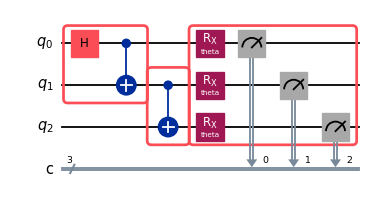

In [2]:
from samplomatic import Twirl

boxed_circuit = QuantumCircuit(3, 3)

# Pauli-twirled box with gates
with boxed_circuit.box(annotations=[Twirl()]):
    boxed_circuit.h(0)
    boxed_circuit.cx(0, 1)

# Pauli-twirled box with gates with a different decomposition
with boxed_circuit.box(annotations=[Twirl(decomposition="rzrx")]):
    boxed_circuit.cx(1, 2)

# Pauli-twirled box with measurements
with boxed_circuit.box(annotations=[Twirl()]):
    boxed_circuit.rx(Parameter("theta"), [0, 1, 2])
    boxed_circuit.measure([0, 1, 2], [0, 1, 2])

boxed_circuit.draw("mpl", scale=0.65)

Each instruction in `boxed_circuit` owns a box, and each box is correctly annotated.

In [3]:
from qiskit.circuit import BoxOp

for idx, instruction in enumerate(boxed_circuit):
    # Each instruction owns a box
    assert isinstance(instruction.operation, BoxOp)

    # Each instruction owns a `Twirl` annotation
    print(f"Annotations of box #{idx}: {instruction.operation.annotations}\n")

Annotations of box #0: [Twirl(group='pauli', dressing='left', decomposition='rzsx')]

Annotations of box #1: [Twirl(group='pauli', dressing='left', decomposition='rzrx')]

Annotations of box #2: [Twirl(group='pauli', dressing='left', decomposition='rzsx')]



## 2. The `build` method

Now that we have constructed a circuit with twirl-annotated boxes, we can use the `build` method of Samplomatic to interpret the circuit into a pair of objects: a "template" `QuantumCircuit` and a `samplex`.

In [4]:
from samplomatic import build

template_circuit, samplex = build(boxed_circuit)

Let us take a look at these two objects.

### The template circuit
The `template_circuit` circuit is structurally equivalent to `boxed_circuit`, meaning that it contains the same two-qubit gates and measurements as `boxed_circuit`. However, its single-qubit gates are different: the original gates are replaced by the dressing gates, synthesized as prescribed by the `Twirl` annotations. These dressing gates are sufficient to implement:
- The single-qubit gates in `boxed_circuit`--in our case, the Hadamard gate and the Pauli-X rotations.
- The Pauli-twirling gates.

In our example, every box is replaced by three barriers labeled "L", "M", and "R" corresponding to their positions ("L" on the left, "M" in the middle, "R" on the right), a block of parametric single-qubit gates implementing the dressing, and the two-qubit gates or measurements originally in the box. Given that the value of `Twirling.dressing` is `"left"` for every box, the parametric single-qubit gates are placed on the left-hand side (between the "L" and "M" barriers) of the corresponding two-qubit gates or measurements. The dressing gates of the first and last box appear as an RZ-SX-RZ-SX-RZ chain, in agreement with the value of `Twirling.decomposition`, while the dressing gates of the central box appear as an RZ-RX-RZ chain.

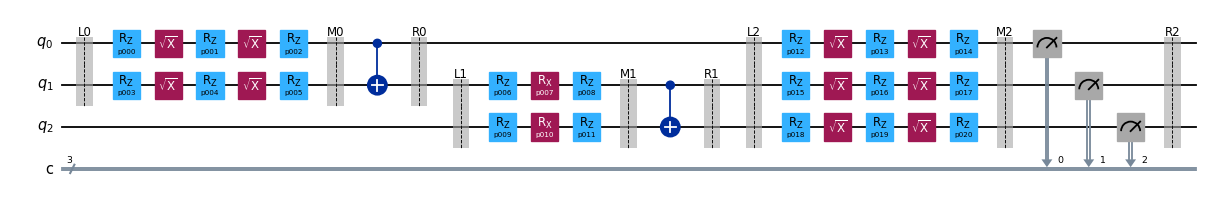

In [5]:
template_circuit.draw("mpl", scale=0.65, fold=100)

#### The samplex

The `samplex` encodes all the information that is required to generate randomized parameters for `template_circuit`. Conceptually, it represents a probability distribution for the parameters in `template_circuit` and for the classical information required to post-process its outputs.

The following cell shows how to generate five sets of parameters for `template_circuit`. As can be seen, the outputs of `samplex.sample` contain:
- The `parameter_values` to implement the Hadamard gate, the RX gates, and the twirling gates. These come in the form of an array of floats of shape `(5, 21)`, where `5` is the number of randomizations and `21` is the number of parameters in the template circuit (hence, `5` sets of `21` randomized parameters).
- The `measurement_flips.c` represents the bit-flips to undo the effect of twirling the measurements and recover the correct results. These come in the form of an array of booleans of shape `(5, 1, 3)`, where `5` is the number of randomizations and `3` is the number of measurements.

In [6]:
# print the samplex to learn its inputs and outputs
print(samplex)

Samplex(<19 nodes>)
  Inputs:
  - 'parameter_values' <float64[1]>: Input parameter values to use during sampling.

  Outputs:
    * 'measurement_flips.c' <bool['num_randomizations', 1, 3]>: Bit-flip corrections for
        measurement twirling.
    * 'parameter_values' <float32['num_randomizations', 21]>: Parameter values valid for an
        associated template circuit.



In [7]:
# specify the value of 'theta'
samplex_input = {"parameter_values": [0.1]}

# use the `samplex.sample` method to sample 5 sets of parameters
outputs = samplex.sample(samplex_input, num_randomizations=5)

# access the sampled values as you'd access values in a dictionary
parameter_values = outputs["parameter_values"]
measurement_flips = outputs["measurement_flips.c"]

In [8]:
# use `describe` for a human-readable description of the outputs
print(f"\nSamplex outputs:")
print(outputs.describe())

print(f"Shape of 'parameter_values': {parameter_values.shape}.")
print(f"Shape of 'measurement_flips.c': {measurement_flips.shape}.\n")


Samplex outputs:
* 'measurement_flips.c' <bool['num_randomizations', 1, 3]>: Bit-flip corrections for measurement twirling.
* 'parameter_values' <float32['num_randomizations', 21]>: Parameter values valid for an associated template circuit.

Shape of 'parameter_values': (5, 21).
Shape of 'measurement_flips.c': (5, 1, 3).



➡️ How can we verify the correctness of these parameters?<br>
Check out Appendix A (bottom of the notebook) for some ideas.

### Where are the random circuits?

So far in this notebook, there are no random circuits. There is our boxed-up circuit that declares twirling intent, there is the template circuit but it is under-specified for randomization, and there is a samplex that defined a distribution over the template circuit's parameters.

However, if we want one all we need to do is bind one of our random parameter values sets to the template circuit! It is no coincidence that the number of parameter in the `template_circuit` match the number of columns of the variable we have named `parameter_values`.

➡️ We will not be sending random circuits to a primitive. Instead, we'll send the whole samplex and the template circuit.

In [9]:
print("Number of parameters in `template_circuit`:", template_circuit.num_parameters)
print("                  `parameter_values` shape:", parameter_values.shape)

Number of parameters in `template_circuit`: 21
                  `parameter_values` shape: (5, 21)


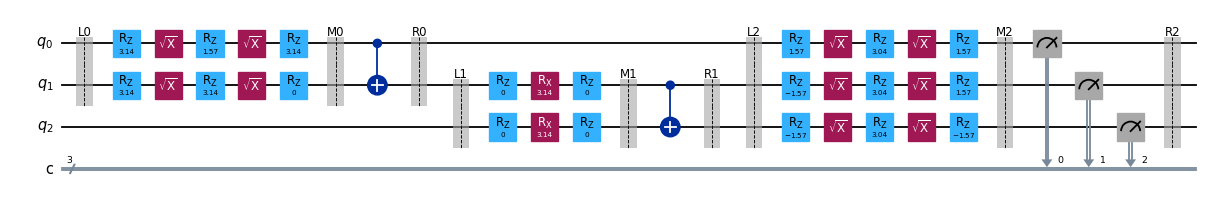

In [10]:
template_circuit.assign_parameters(parameter_values[0]).draw("mpl", scale=0.65, fold=100)

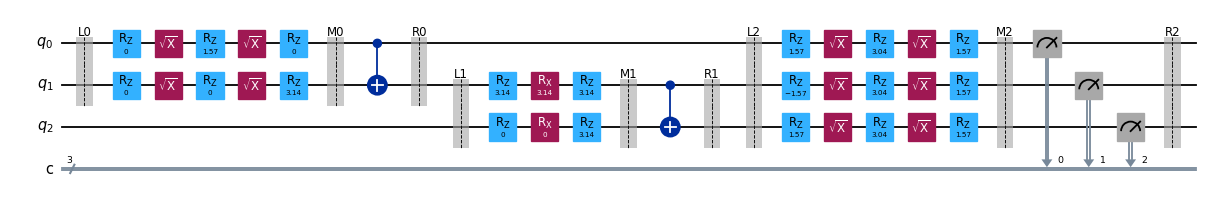

In [11]:
template_circuit.assign_parameters(parameter_values[1]).draw("mpl", scale=0.65, fold=100)

### The samplex as a DAG

The `samplex` object is implemented as a Directed Acyclic Graph (DAG) accessible via `samplex.graph`. Each node in the graph represents a different procedure to either:
- **Sample** elements from a set, such as the set of all Paulis in the case of Pauli twirling.
- **Process** the sampled elements, for example:
  -  To commute them with a gate.
  -  To combine many into one.
  -  Or to change their representation - for example, to convert a Pauli operator into the equivalent U2 gate representation.
- **Convert** the resulting objects into parameters for `template_circuit`.

The edges represent dependencies between nodes. In particular, an edge from node A to node B indicates that the task of B depends on A and cannot be executed before the task of A is executed.

> **_NOTE:_**  Given its internal implementation as a graph, multiple sampling, processing, and convertion steps can be carried out in parallel, making the samplex highly efficient at generating random sets of parameters. 

The two cells below show the `samplex` for our GHZ circuit, alongside `template_circuit` for clarity. In the following we explain the role of each node following execution order, in the simple case where a single set of parameters is produced.

The three red stars (one per box) are the nodes in charge of generating of random Pauli gates. Each of these nodes generates two instances of a randomly-chosen Pauli operator, with support on as many qubits as are in the box. Intuitively, one can think of them as a pair of "virtual" (non-physical) gates generated on top of the barriers marked as ``M``, as illustrated by the stars in the `template_circuit` figure.

After the virtual Pauli pairs are generated, they travel through the circuit in opposite directions, one towards the beginning of the circuit and one towards the end. The green circles in the `samplex` keep track of their evolution as they commute through gates, or are combined with other virtual Paulis that they meet along the way.

When the virtual Paulis meet parametric single-qubit gates or measurements, their journey ends. The bow-tie nodes convert them into parameter values for the template circuit (the blue bow ties) or into an array of measurement flips (the purple bow tie).

In [12]:
# The numbers in each node represent the indices of the nodes in the underlying
# `samplex.graph` object.

fig = samplex.draw()
fig.update_layout(width=900, height=250)
fig.show()

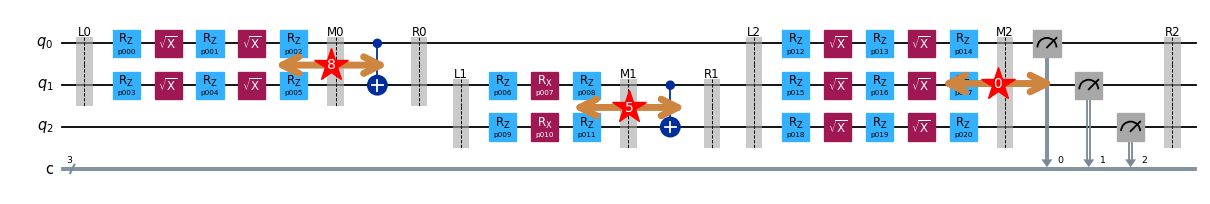

In [13]:
from IPython.display import display
from qiskit.visualization import circuit_drawer
from matplotlib.patches import FancyArrowPatch

fig = circuit_drawer(template_circuit, output="mpl", scale=0.65, fold=100)
ax = fig.gca()

pos = [(0.27, 0.7), (0.52, 0.47), (0.83, 0.6)]

for (x, y), text in zip(pos, ["8", "5", "0"]):
    ax.plot(x, y, marker="*", color="red", markersize=25, zorder=100, transform=ax.transAxes)
    ax.text(x, y, text, color="white", ha="center", va="center", fontsize=10, zorder=101, transform=ax.transAxes)


for idx, (x, y) in enumerate(pos):
    arrow = FancyArrowPatch(
        (x-0.05, y),
        (x+0.05, y),
        arrowstyle="<->",
        transform=ax.transAxes,
        zorder=99,
        mutation_scale=30,
        linewidth=5,
        color="peru",
    )
    ax.add_patch(arrow)

display(fig)

➡️ How does the number of nodes in the graph scale with the size of the circuit?<br>
Check out Appendix B (bottom of the notebook) for some ideas.

## 3. A PassManager to box your circuits

Many users may not be interested in manually dividing their circuit into boxes.
In such a case, they can use the transpiler pass manager in samplomatic to perform this process for them.
The following snippet creates a pass manager that groups gates into boxes, but leaves the measurements outside.

In [14]:
from samplomatic.transpiler import generate_boxing_pass_manager

boxing_pass_manager = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=False,
)

Running this pass manager with the three-qubit GHZ circuit generates the following circuit.

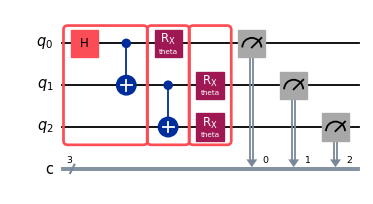

In [15]:
circuit = QuantumCircuit(3, 3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.rx(Parameter("theta"), [0, 1, 2])
circuit.measure([0, 1, 2], [0, 1, 2])

boxed_circuit = boxing_pass_manager.run(circuit)

boxed_circuit.draw("mpl", scale=0.65)

In [16]:
for idx, instruction in enumerate(boxed_circuit):
    if isinstance(instruction.operation, BoxOp):
        print(f"Annotations of box #{idx}: {instruction.operation.annotations}\n")

Annotations of box #0: [Twirl(group='pauli', dressing='left', decomposition='rzsx')]

Annotations of box #1: [Twirl(group='pauli', dressing='left', decomposition='rzsx')]

Annotations of box #2: [Twirl(group='pauli', dressing='right', decomposition='rzsx')]



The boxing pass managers can be used in conjunction with other pass managers - for example, with one of the Qiskit preset pass managers.

In [17]:
from qiskit.transpiler import generate_preset_pass_manager

preset_pass_manager = generate_preset_pass_manager(
    basis_gates=["rz", "sx", "cx"],
    coupling_map=[[0, 1], [0, 2]],  # No CX gate between qubits 1 and 2
    optimization_level=0,
)

# Run the boxing pass manager after the scheduling stage, i.e., at the
# very end of the transpilation (since scheduling is the last stage)
preset_pass_manager.post_scheduling = boxing_pass_manager

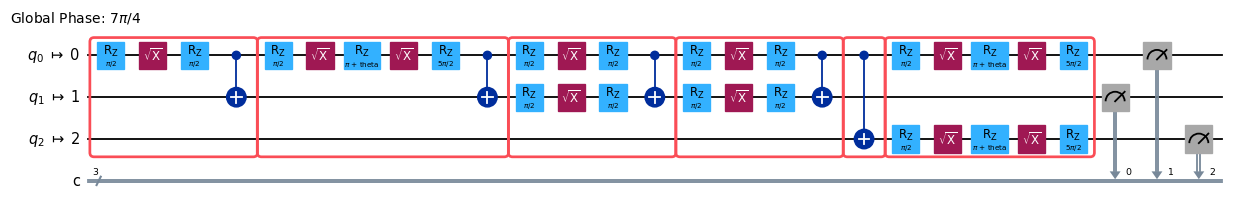

In [18]:
circuit = QuantumCircuit(3, 3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.rx(Parameter("theta"), [0, 1, 2])
circuit.measure([0, 1, 2], [0, 1, 2])

boxed_circuit = preset_pass_manager.run(circuit)

boxed_circuit.draw("mpl", scale=0.65, fold=100)

## 4. The `InjectNoise` annotation

`InjectNoise` is a directive to use the dressers to inject noise into our circuits. It is designed to be flexible and support a wide range of applications for error mitigation.

Every `InjectNoise` comes with:
- An `InjectNoise.ref` attribute. This is a unique identifier attached to each of these annotations, and it is required by the samplex to correctly assign a noise model to each box.
- An optional `InjectNoise.modifier_ref`, which allows scaling the noise model assigned to a box by multiplicative factors.

The following snippet shows how to add an `InjectNoise` annotation to the gate boxes in our three-qubit GHZ circuit manually.
The function `generate_boxing_pass_manager` also has arguments that cause the pass manager to insert these annotations.

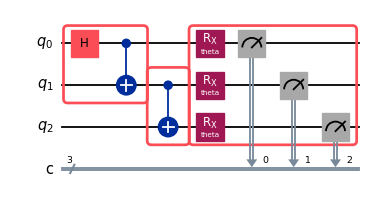

In [19]:
from samplomatic import InjectNoise

boxed_circuit = QuantumCircuit(3, 3)

# The choice of 'r0' and 'm0' is arbitrary: `ref` and `modifier_ref` can be any string
with boxed_circuit.box(annotations=[Twirl(), InjectNoise(ref="r0", modifier_ref="m0")]):
    boxed_circuit.h(0)
    boxed_circuit.cx(0, 1)

with boxed_circuit.box(annotations=[Twirl(), InjectNoise(ref="r1", modifier_ref="m1")]):
    boxed_circuit.cx(1, 2)

with boxed_circuit.box(annotations=[Twirl()]):
    boxed_circuit.rx(Parameter("theta"), [0, 1, 2])
    boxed_circuit.measure([0, 1, 2], [0, 1, 2])

boxed_circuit.draw("mpl", scale=0.65)

In [20]:
for idx, instruction in enumerate(boxed_circuit):
    # Each instruction owns a box
    assert isinstance(instruction.operation, BoxOp)

    # Each instruction owns `Twirl` and `InjectNoise` annotations
    print(f"Annotations of box #{idx}:\n {instruction.operation.annotations}\n")

Annotations of box #0:
 [Twirl(group='pauli', dressing='left', decomposition='rzsx'), InjectNoise(ref='r0', modifier_ref='m0', site='before')]

Annotations of box #1:
 [Twirl(group='pauli', dressing='left', decomposition='rzsx'), InjectNoise(ref='r1', modifier_ref='m1', site='before')]

Annotations of box #2:
 [Twirl(group='pauli', dressing='left', decomposition='rzsx')]



Using the `build` method, we construct the template circuit and the samplex.

In [21]:
template_circuit, samplex = build(boxed_circuit)

In [22]:
# print the samplex to learn its inputs and outputs
print(samplex)

Samplex(<23 nodes>)
  Inputs:
  - 'parameter_values' <float64[1]>: Input parameter values to use during sampling.
  - 'pauli_lindblad_maps.r0' <PauliLindbladMap>: A PauliLindblad map acting on 2 qubits, with
      'num_terms_r0' terms.
  - 'pauli_lindblad_maps.r1' <PauliLindbladMap>: A PauliLindblad map acting on 2 qubits, with
      'num_terms_r1' terms.

  - 'local_scales.m0' <float64['num_terms_r0']>: (Optional) An array of factors by which to
      scale individual rates of a Pauli Lindblad map, where the order should match the
      corresponding list of terms.
  - 'local_scales.m1' <float64['num_terms_r1']>: (Optional) An array of factors by which to
      scale individual rates of a Pauli Lindblad map, where the order should match the
      corresponding list of terms.
  - 'noise_scales.m0' <float64[]>: (Optional) A scalar factor by which to scale rates of a
      Pauli Lindblad map.
  - 'noise_scales.m1' <float64[]>: (Optional) A scalar factor by which to scale rates of a
     

<details>
    <summary>What is a Pauli Lindblad map?</summary>

An error channel $\mathcal{E}$ acting on a state $\rho$ can be expressed in Pauli Lindblad format as $\mathcal{E}(\rho) = e^{\sum_j r_j D_{P_j}}(\rho)$, where $P_j$ are Pauli operators (or "generators") and $r_j$ are floats (or "rates"); see [Probabilistic error cancellation with sparse Pauli–Lindblad models on noisy quantum processors](https://arxiv.org/abs/2201.09866) for details. The equivalent Pauli error channel can be constructed as a composition of single-Pauli channel terms

$$ \mathcal{E} = e^{\sum_j r_j D_{P_j}} = \prod_j e^{r_j D_{P_j}}
    = \prod_j \left( (1 - p_j) S_I + p_j S_{P_j} \right),$$

where $p_j = \frac12 - \frac12 e^{-2 r_j}$.
</details>

In [23]:
from qiskit.quantum_info import PauliLindbladMap

# specify the values required by the samplex
samplex_input = {
    "parameter_values": [0.1],
    "pauli_lindblad_maps.r0": PauliLindbladMap.from_list([("IX", 0.04), ("XX", 0.05)]),
    "pauli_lindblad_maps.r1": PauliLindbladMap.from_list([("XI", 0.02), ("IZ", 0.035)]),
    "noise_scales.m0": 1.2,
}

outputs = samplex.sample(samplex_input, num_randomizations=5)

# use `describe` for a human-readable description of the outputs
print(f"\nSamplex outputs:")
print(outputs.describe())


Samplex outputs:
* 'measurement_flips.c' <bool['num_randomizations', 1, 3]>: Bit-flip corrections for measurement twirling.
* 'parameter_values' <float32['num_randomizations', 21]>: Parameter values valid for an associated template circuit.
* 'pauli_signs' <bool['num_randomizations', 2]>: Signs from sampled Pauli Lindblad maps, where boolean values represent the parity of the number of non-trivial factors in the sampled error that arise from negative rates. In other words, in order to implement basic PEC, the sign used to correct expectation values should be ``(-1)**bool_value``. The order matches the iteration order of boxes in the original circuit with noise injection annotations.



The `template_circuit` is equal to the circuit that we get in the absence of noise injection.

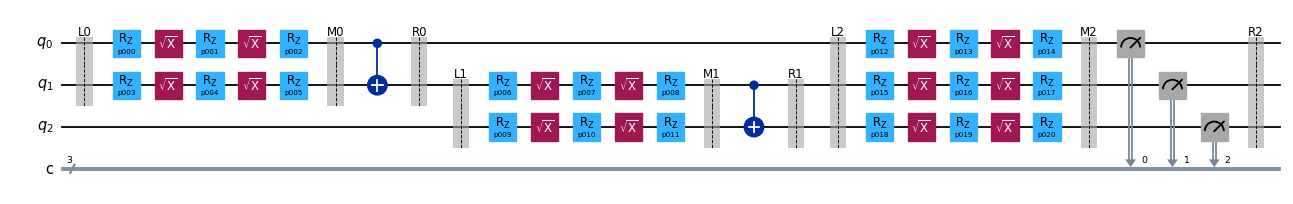

In [24]:
template_circuit.draw("mpl", scale=0.65, fold=100)

However, the `samplex` is different. In particular, we notice that the number of sampling nodes (the red star) has increased. The two new nodes are responsible for sampling Pauli terms for the noise injection.

In [25]:
fig = samplex.draw()
fig.update_layout(width=900, height=250)
fig.show()

### Extras on the `InjectNoise` annotation

<details>
    <summary>What's the difference between noise scales and local scales?</summary>
    As can be seen above, both of them are optional inputs. However, the required type is different. In particular, a noise scale is a float that allows scaling noise models uniformly, meaning that each term in the noise model is scaled by the same multiplicative factor. On the contrary, local scales are arrays of floats that allow scaling the terms in the noise model by individual factors.
</details>

<details>
    <summary>What about the Pauli signs?</summary>
    The Pauli signs are provided as an array of booleans. In our example, this array has two axes, one (the l.h.s.) over randomizations and the other (the r.h.s.) over noise injection sites. The values in this array represent the parity of the number of non-trivial factors in the sampled error that arise from negative rates. In other words, when using
the boolean written by this node to implement basic PEC, the sign used to correct expectation values
should be `(-1)**bool_value`
</details>

## 5. The `ChangeBasis` annotation

`ChangeBasis` is a directive to add basis changing gates to a box. It supports two different modes:

- `"prepare"`, typically used at the beginning of a circuit to map eigenstates of Pauli-Z to eigenstates of Pauli-X or Pauli-Y.
- `"measure"`, typically used to change basis prior to measurements to map eigenstates of Pauli-X and Pauli-Y to eigenstates of Pauli-Z.

The following snippet shows how to add a `ChangeBasis` to the measurement box of our three-qubit GHZ state:

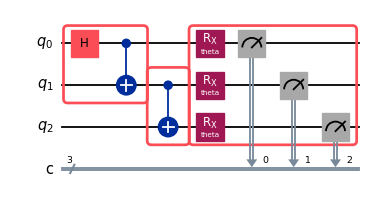

In [26]:
from samplomatic import ChangeBasis

boxed_circuit = QuantumCircuit(3, 3)

with boxed_circuit.box(annotations=[Twirl()]):
    boxed_circuit.h(0)
    boxed_circuit.cx(0, 1)

with boxed_circuit.box(annotations=[Twirl()]):
    boxed_circuit.cx(1, 2)

# Add basis-changing gates
with boxed_circuit.box(annotations=[Twirl(), ChangeBasis(mode="measure", ref="conclude")]):
    boxed_circuit.rx(Parameter("theta"), [0, 1, 2])
    boxed_circuit.measure([0, 1, 2], [0, 1, 2])

boxed_circuit.draw("mpl", scale=0.65)

In [27]:
for idx, instruction in enumerate(boxed_circuit):
    # Each instruction owns a box
    assert isinstance(instruction.operation, BoxOp)

    # Each instruction owns a `Twirl` annotation, and the measurement instruction a `ChangeBasis`
    print(f"Annotations of box #{idx}:\n {instruction.operation.annotations}\n")

Annotations of box #0:
 [Twirl(group='pauli', dressing='left', decomposition='rzsx')]

Annotations of box #1:
 [Twirl(group='pauli', dressing='left', decomposition='rzsx')]

Annotations of box #2:
 [Twirl(group='pauli', dressing='left', decomposition='rzsx'), ChangeBasis(decomposition='rzsx', dressing='left', mode='measure', ref='conclude')]



In [28]:
template_circuit, samplex = build(boxed_circuit)

In [29]:
# print the samplex to learn its inputs and outputs
print(samplex)

Samplex(<20 nodes>)
  Inputs:
  - 'basis_changes.conclude' <uint8[3]>: Basis changing gates, in the symplectic ordering
      I=0, Z=1, X=2, and Y=3.
  - 'parameter_values' <float64[1]>: Input parameter values to use during sampling.

  Outputs:
    * 'measurement_flips.c' <bool['num_randomizations', 1, 3]>: Bit-flip corrections for
        measurement twirling.
    * 'parameter_values' <float32['num_randomizations', 21]>: Parameter values valid for an
        associated template circuit.



In [30]:
from qiskit.quantum_info import PauliLindbladMap

# specify the values required by the samplex
samplex_input = {
    "parameter_values": [0.1],
    "basis_changes.conclude": [0, 2, 3],
}

outputs = samplex.sample(
    samplex_input=samplex_input,
    num_randomizations=5,
)

# use `describe` for a human-readable description of the outputs
print(f"\nSamplex outputs:")
print(outputs.describe())


Samplex outputs:
* 'measurement_flips.c' <bool['num_randomizations', 1, 3]>: Bit-flip corrections for measurement twirling.
* 'parameter_values' <float32['num_randomizations', 21]>: Parameter values valid for an associated template circuit.



The `template_circuit` is equal to the circuit that we get in the absence of `BasisChange` annotations.

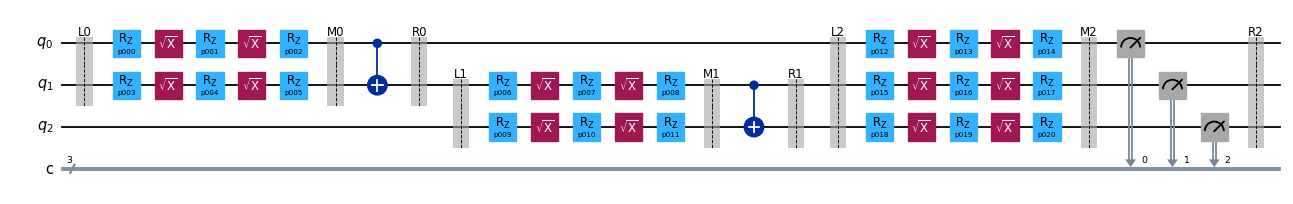

In [31]:
template_circuit.draw("mpl", scale=0.65, fold=100)

But again, `samplex` is different. There is an additional sampling node that is responsible for generating virtual changing-basis gates. These gates travel alongside the virtual Pauli-twirling gates, and are eventually collected by dressing gates.

In [32]:
fig = samplex.draw()
fig.update_layout(width=900, height=250)
fig.show()

## 6. Our new Qiskit Runtime programs: `NoiseLearnerV3` and `Executor`

To allow you to take full advantage of Samplomatic, we have recently developed two new box-centric Qiskit Runtime programs:
- The `NoiseLearnerV3`, which can be used to learn the noise affecting noisy box instructions.
- The `Executor`, which seamlessly integrates Samplomatic concepts such as `circuit_template` and `samplex` into the pipeline.

In this section, we learn how to use these two programs. To do so, we consider a mirrored-version of a circuit with ten qubits and two unique layers of CX gates. We focus on two tasks:
- Execute the circuit with twirling.
- Execute the circuit with PEC mitigation, as in [Probabilistic error cancellation with sparse Pauli–Lindblad models on noisy quantum processors](https://arxiv.org/abs/2201.09866).

Our pipeline consists of three steps:
1. Preparation step, where we generate our target circuit and group its operations into boxes.
2. Learning step, where we learn the noise of the instructions that we wish to mitigate with PEC.
3. Execution step, where we execute our circuit on a backend and analyze the results.

Before moving onto step 1, we choose a backend to execute our experiments on.

In [33]:
from qiskit_ibm_runtime import QiskitRuntimeService

token = "Gjh25PFcrvzE19-WgyvCual_OsEVv7W_jLrawsxpLQiK"

# This is used to retrieve shared results
shared_service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    token=token,
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/04d378db635748bda68d1bb00f37a28f:da36f19f-0a0c-4994-8791-61869cd7996c::"
)


backend = shared_service.backend("ibm_marrakesh")

qiskit_runtime_service._discover_account:WARNING:2026-02-03 08:18:19,726: Loading account with the given token. A saved account will not be used.


### 4.1 Preparation

We now initialize our ten-qubit circuit...

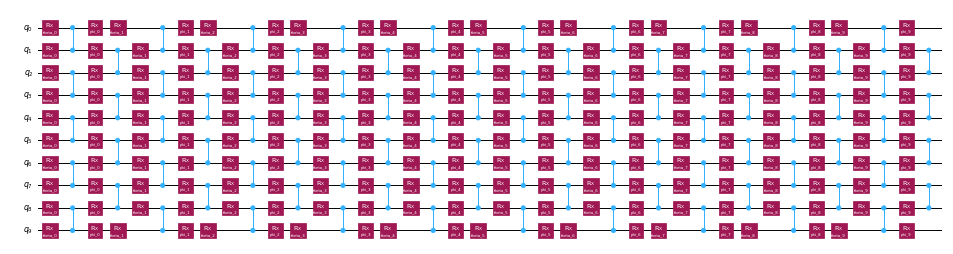

In [34]:
num_qubits = 10
num_layers = 10

qubits = list(range(num_qubits))
circuit = QuantumCircuit(num_qubits)

for layer_idx in range(num_layers):
    circuit.rx(Parameter(f"theta_{layer_idx}"), qubits)
    for i in range(num_qubits // 2):
        circuit.cz(qubits[2 * i], qubits[2 * i + 1])

    circuit.rx(Parameter(f"phi_{layer_idx}"), qubits)
    for i in range(num_qubits // 2 - 1):
        circuit.cz(qubits[2 * i] + 1, qubits[2 * i + 1] + 1)

circuit.draw("mpl", scale=0.35, fold=100)

... and combine it with its inverse to create a mirror circuit.

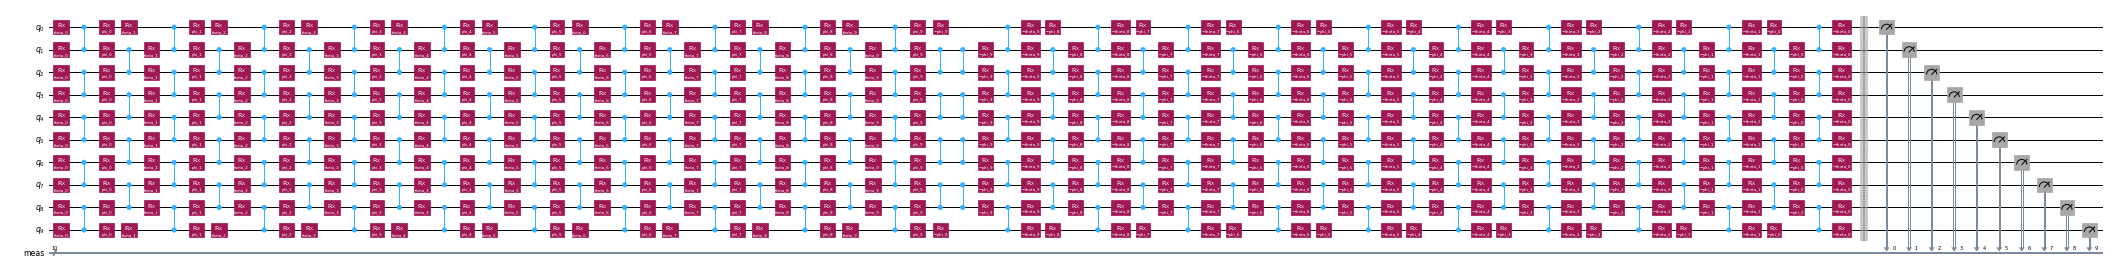

In [35]:
mirror_circuit = circuit.compose(circuit.inverse())
mirror_circuit.measure_all()

mirror_circuit.draw("mpl", scale=0.35, fold=100)

We also set some parameter values:

In [36]:
import numpy as np

parameter_values=np.random.rand(mirror_circuit.num_parameters)

We proceed by utilizing the pass manager to transpile the circuit against our backend, as well as to group gates and measurements into annotated boxes. We begin with creating a circuit with twirled-annotated boxes.

In [37]:
preset_pass_manager = generate_preset_pass_manager(
    backend=backend,
    initial_layout=list(range(40, 50)),  # qubits 40 to 50
    optimization_level=0,
)

# Run the boxing pass manager after the scheduling stage
preset_pass_manager.post_scheduling = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=True,
)

mirror_circuit_twirl = preset_pass_manager.run(mirror_circuit)

Next, we generate a new boxed circuit with `Twirl` and `InjectNoise` annotations.

In [38]:
preset_pass_manager = generate_preset_pass_manager(
    backend=backend,
    initial_layout=list(range(40, 50)),
    optimization_level=0,
)

# Run the boxing pass manager after the scheduling stage
preset_pass_manager.post_scheduling = generate_boxing_pass_manager(
    enable_gates=True,
    enable_measures=True,
    inject_noise_targets="gates",  # no measurement mitigation
    inject_noise_strategy="uniform_modification",
)

mirror_circuit_pec = preset_pass_manager.run(mirror_circuit)

### 4.2 Learning

To minimize the number of noise learning experiments, we begin by identifying the unique instructions in our second circuit (the one with boxes annotated with `InjectNoise`). In defining uniqueness, we say that two box instructions are equal if:
- Their content is equal, up to single-qubit gates.
- Their `Twirl` annotation is equal (every other annotation is disregarded).

This leads to three unique instructions, namely the odd and even gate boxes, and the final measurement box.

In [39]:
from samplomatic.utils import find_unique_box_instructions

unique_box_instructions = find_unique_box_instructions(mirror_circuit_pec.data)
assert len(unique_box_instructions) == 3

We can now initialize a `NoiseLearnerV3`, choose the learning parameters by setting its options, and run a noise learning job.

In [40]:
from qiskit_ibm_runtime.noise_learner_v3 import NoiseLearnerV3

use_cached_results = True

if use_cached_results:
    learner_job = shared_service.job("d60h4j1mvbjc73adjvp0")
else:
    learner = NoiseLearnerV3(backend)

    learner.options.shots_per_randomization = 128
    learner.options.num_randomizations = 32
    learner.options.layer_pair_depths = [0, 1, 2, 4, 16, 32]

    learner_job = learner.run(unique_box_instructions)

learner_job

<RuntimeJobV2('d60h4j1mvbjc73adjvp0', 'noise-learner')>

In [41]:
learner_result = learner_job.result()

To convert `result` to the object required by the samplex, we use the `result.to_dict` method.

In [42]:
noise_maps = learner_result.to_dict(instructions=unique_box_instructions, require_refs=False)
noise_maps;

### 4.3 Execution

The `Executor` runs `QuantumProgram` objects. Each `QuantumProgram` is able to contain several *items*, which you can think of as a pair of template and samplex.

We initialize an empty program, requesting `1000` shots for each of its items.

In [43]:
from qiskit_ibm_runtime.quantum_program import QuantumProgram

# Generate a quantum program
program = QuantumProgram(shots=1000)

Next, we append the template and samplex built for `mirror_circuit_twirl`, requesting `900` randomizations. This means that the samplex will produce `900` sets of parameters, and each of them will be executed `1000` times in the QPU.

In [44]:
template_twirl, samplex_twirl = build(mirror_circuit_twirl)

program.append(
    template_twirl,
    samplex=samplex_twirl,
    samplex_arguments={"parameter_values": parameter_values},
    shape=(900,)
)

Similarly, we append the template and samplex built for `mirror_circuit_pec`, requesting `900` randomizations.

In [45]:
template_pec, samplex_pec = build(mirror_circuit_pec)

program.append(
    template_pec,
    samplex=samplex_pec,
    samplex_arguments={
        "parameter_values": parameter_values,
        "pauli_lindblad_maps": noise_maps,
        "noise_scales": {ref: -1.0 for ref in noise_maps}  # Set the scales to -1 for PEC
    },
    shape=(900,)
)

We can now import the `Executor` and submit a job.

In [46]:
from qiskit_ibm_runtime.executor import Executor

use_cached_results = True

if use_cached_results:
    executor_job = shared_service.job("d60h7dibju6s73bd0lv0")
else:
    executor = Executor(backend)
    executor_job = executor.run(program)

executor_job.job_id()

'd60h7dibju6s73bd0lv0'

In [47]:
executor_results = executor_job.result()
executor_results

QuantumProgramResult(<2 results>)

In [48]:
twirl_result = executor_results[0]

print(f"Twirl result keys:\n {list(twirl_result.keys())}\n")
print(f"Shape of results: {twirl_result['meas'].shape}")

Twirl result keys:
 ['meas', 'measurement_flips.meas']

Shape of results: (900, 1000, 10)


In [49]:
pec_result = executor_results[1]

print(f"PEC result keys:\n {list(pec_result.keys())}\n")
print(f"Shape of results: {pec_result['meas'].shape}")

PEC result keys:
 ['meas', 'measurement_flips.meas', 'pauli_signs']

Shape of results: (900, 1000, 10)


The next two cells show how to post-process the results to estimate the expectation values of single-qubit Pauli-Z operators acting on each of the ten active qubits (expected value: `1.0`).

In [50]:
# Undo measurement twirling
twirl_result_unflipped = twirl_result["meas"] ^ twirl_result["measurement_flips.meas"]

# Calculate the expectation values of single-qubit Z operators
twirl_exp_vals = 1 - 2 * twirl_result_unflipped.mean(axis=1).mean(axis=0)

for qubit, val in enumerate(twirl_exp_vals):
    print(f"Qubit {qubit} -> {np.round(val, 2)}")

Qubit 0 -> 0.0
Qubit 1 -> 0.01
Qubit 2 -> -0.0
Qubit 3 -> 0.07
Qubit 4 -> 0.11
Qubit 5 -> 0.22
Qubit 6 -> 0.27
Qubit 7 -> 0.34
Qubit 8 -> 0.34
Qubit 9 -> 0.52


In [51]:
# Undo measurement twirling
pec_result_unflipped = pec_result["meas"] ^ pec_result["measurement_flips.meas"]

# Calculate the signs for PEC mitigation
signs = np.prod((-1)**pec_result["pauli_signs"], axis=-1)
signs = signs.reshape((signs.shape[0], 1))

# Calculate the expectation values of single-qubit Z operators as required by
# PEC mitigation
pec_exp_vals = 1 - (2 * pec_result_unflipped.mean(axis=1) * signs).mean(axis=0)

for qubit, val in enumerate(pec_exp_vals):
    print(f"Qubit {qubit} -> {np.round(val, 2)}")

Qubit 0 -> 1.02
Qubit 1 -> 1.02
Qubit 2 -> 1.02
Qubit 3 -> 1.02
Qubit 4 -> 1.02
Qubit 5 -> 1.02
Qubit 6 -> 1.01
Qubit 7 -> 1.02
Qubit 8 -> 1.01
Qubit 9 -> 1.02


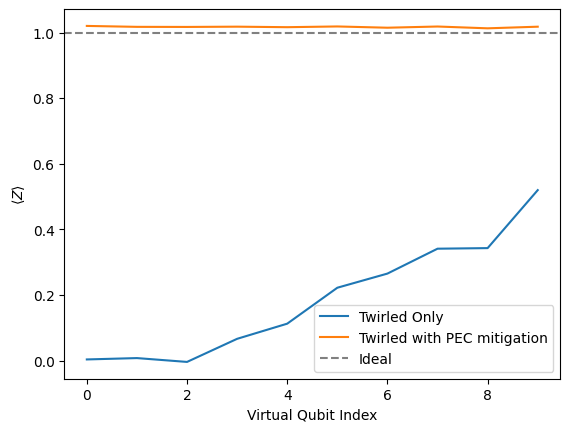

In [52]:
import matplotlib.pyplot as plt

plt.plot(twirl_exp_vals, label="Twirled Only")
plt.plot(pec_exp_vals, label="Twirled with PEC mitigation")
plt.axhline(1, label="Ideal", c="gray", ls="--")

plt.xlabel("Virtual Qubit Index")
plt.ylabel(r"$\langle Z \rangle$")
plt.legend()

# Appendix

## A. Verifying the correctness of the parameters generated by `samplex.sample`.

For circuits of limited size, we can verify the correctness of the parameters generated by `samplex.sample` by:
- Assigning the parameter values to `template_circuit`.
- Using Qiskit's `Operator` class, verifying that the resulting circuit is equivalent to the circuit that we started from.

To see an example, consider the three-qubit GHZ circuit...

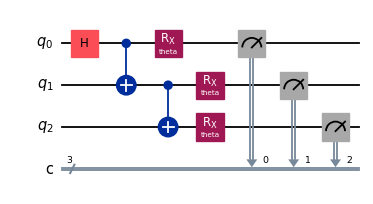

In [53]:
# initialize the GHZ circuit
circuit = QuantumCircuit(3, 3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.rx(Parameter("theta"), [0, 1, 2])
circuit.measure([0, 1, 2], [0, 1, 2])

circuit.draw("mpl", scale=0.65)

... and its boxed-up version.

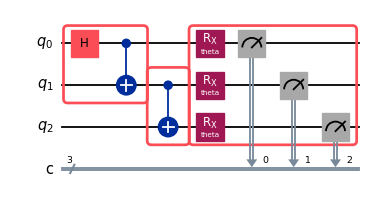

In [54]:
boxed_circuit = QuantumCircuit(3, 3)

with boxed_circuit.box(annotations=[Twirl()]):
    boxed_circuit.h(0)
    boxed_circuit.cx(0, 1)

with boxed_circuit.box(annotations=[Twirl()]):
    boxed_circuit.cx(1, 2)

# Add basis-changing gates
with boxed_circuit.box(annotations=[Twirl(), ChangeBasis(mode="measure", ref="conclude")]):
    boxed_circuit.rx(Parameter("theta"), [0, 1, 2])
    boxed_circuit.measure([0, 1, 2], [0, 1, 2])

boxed_circuit.draw("mpl", scale=0.65)

We build the template and samplex for the circuit above and generate `6` sets of parameters.

In [55]:
template_circuit, samplex = build(boxed_circuit)

# specify the values required by the samplex
samplex_input = {
    "parameter_values": [theta := 0.1],
    "basis_changes.conclude": [0, 2, 3],
}

outputs = samplex.sample(
    samplex_input=samplex_input,
    num_randomizations=6,
)

We can now visualize the unitary implemented by the original circuit as follows:

Text(0.5, 1.0, 'Non-randomized circuit')

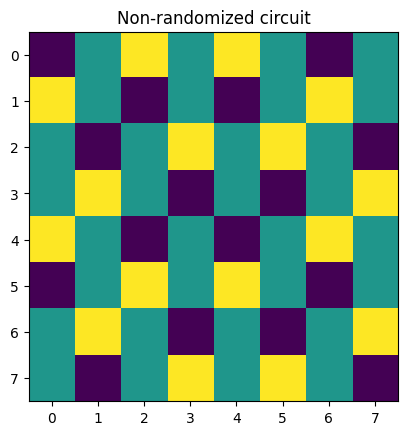

In [56]:
from qiskit.quantum_info import Operator, Pauli
import matplotlib.pyplot as plt

# Remove measurements
circuit.remove_final_measurements()

# Add basis changing gates
circuit.h(1)
circuit.sx(2)
unitary = Operator(circuit.assign_parameters([theta]))

# Plot magnitudes of the unitary matrix representation of the circuit
plt.imshow(np.abs(unitary))
plt.title("Non-randomized circuit")

If we assign the parameter values generated by the `samplex` to the `template_circuit`, we get identical plots!

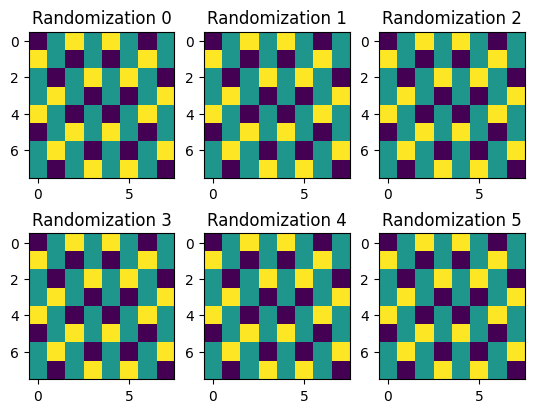

In [57]:
plt.subplot(2, 3, 1)

# For each randomization we sampled, plot the unitary matrix representation
for idx in range(6):
    bound_template = template_circuit.assign_parameters(outputs["parameter_values"][idx])
    bound_template.remove_final_measurements()

    meas_flips = Pauli(([0] * boxed_circuit.num_qubits, outputs["measurement_flips.c"][idx, 0]))
    bound_unitary = Operator(bound_template) & meas_flips

    # Plot magnitudes of the unitary matrix represenation of the circuit
    plt.subplot(2, 3, idx + 1)
    plt.imshow(np.abs(bound_unitary))
    plt.title(f"Randomization {idx}")

## B. How the `samplex` graph scales with the size of our circuits 

When a circuit contains a larger number of qubits and instructions, the number of nodes in the samplex graph grows accordingly. Yet, given its implementation as a graph, the samplex remains highly performant. 

To get a sense of how the samplex grows, consider the following circuit, which is easy to scale both in number of qubits and in depth.

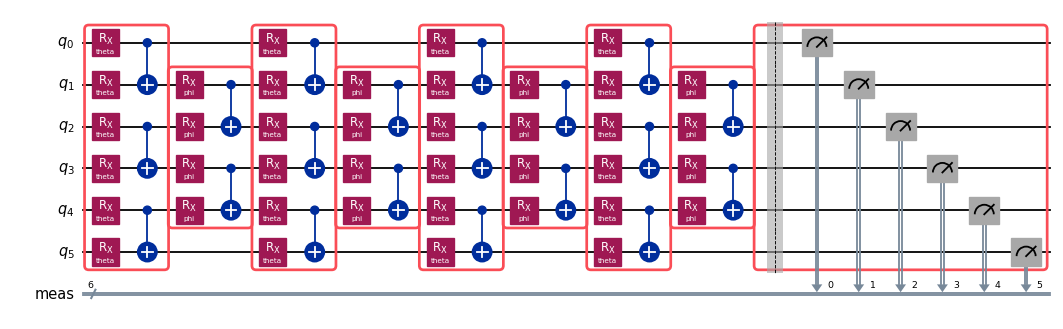

In [58]:
# Increase `num_qubits` and `num_layers` to see how the samplex changes
num_qubits = 6
num_layers = 4

if num_qubits % 2 != 0:
    raise ValueError(f"Please provide an even value for 'num_qubits'.")

boxed_circuit = QuantumCircuit(num_qubits)

theta = Parameter("theta")
phi = Parameter("phi")

for _ in range(num_layers):
    with boxed_circuit.box([Twirl()]):
        boxed_circuit.rx(theta, range(num_qubits))
        boxed_circuit.cx(range(0, num_qubits - 1, 2), range(1, num_qubits, 2))

    with boxed_circuit.box([Twirl()]):
        boxed_circuit.rx(phi, range(1, num_qubits-1))
        boxed_circuit.cx(range(1, num_qubits - 1, 2), range(2, num_qubits, 2))

with boxed_circuit.box([Twirl()]):
    boxed_circuit.measure_all()

boxed_circuit.draw("mpl", scale=0.65, fold=100)

The number of nodes in the `samplex` has grown considerably!

In [59]:
template_circuit, samplex = build(boxed_circuit)

fig = samplex.draw()
fig.update_layout(width=900, height=400)
fig.show()